# HSLS Preproccessing

What I do in this file 
* Pkl files without imputation
* Pkl files with imputation
* Pkl files with Teacher variables

New: All pkl files include 8th grade past performance

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss

import sys
sys.path.append("../../../core")
#from preprocessing import *


### Set Pandas options to display all rows and columns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=np.inf)
from captum.attr import IntegratedGradients

### Supress warnings
import warnings; warnings.simplefilter('ignore')


In [35]:
student_pets = pd.read_csv("data/hsls_17_student_pets_sr_v1_0.csv")
school = pd.read_csv("data/hsls_09_school_v1_0.csv")

In [36]:
student_pets.shape

(23503, 9614)

In [37]:
student_vars = ['X1SEX', 'X1RACE', 'X1HHNUMBER', 'X1FAMINCOME','X1PAR1EDU', 'X1PAR2EDU', 'X1PAR1OCC2', 'X1PAR2OCC2',
                'X1MTHID', 'X1MTHUTI', 'X1MTHEFF', 'X1MTHINT',
                'S1LANG1ST', 'S1TEPOPULAR', 'S1TEMAKEFUN', 'S1MTHCOMP', 'S1SCICOMP',
                'S1MTCHRESPCT', 'S1MTCHFAIR', 'S1MTCHINTRST', 'S1MTCHEASY', 'S1MTCHVALUES', 'S1MTCHCONF',
                'S1APCALC', 'S1IBCALC']

# P1ELLNOW, P1USBORN9, P1USYR9 is majority non-respondents
parent_vars = ['P1REPEATGRD', 'P1ELLEVER',
               'P1MARSTAT', 'P1YRBORN1', 'P1YRBORN2', 'X1PAR1RACE', 'X1PAR2RACE', 'P1USBORN1', 'P1USBORN2', 
               'X1PAR1EDU', 'X1PAR2EDU', 'X1PAR1OCC2', 'X1PAR2OCC2',
               'P1JOBNOW1', 'P2JOBNOW1', 'P1JOBONET1_STEM1', 'P1JOBONET2_STEM1',
               'X1PARRESP', 'X1P1RELATION', 'P1HHTIME', 'P1EDUASPIRE', 'P1EDUEXPECT',
               'P1MTHHWEFF', 'P1SCIHWEFF', 'P1ENGHWEFF', 'P1MTHCOMP', 'P1SCICOMP', 'P1ENGCOMP',
               'P1MUSEUM', 'P1COMPUTER','P1FIXED', 'P1SCIFAIR', 'P1SCIPROJ', 'P1STEMDISC', 'P1CAMPMS', 'P1CAMPOTH',
               'P1NOOUTSCH', 'P1NOACT']

teacher_vars = ['M1SEX']

teacher_vars2 = ['M1HIDEG', 'M1HIMAJ2', 'M1HIDEGYR', 'M1BASCHED', 'M1HIDEGSCHED',
                'M1ALGEBRA', 'M1APPLIEDMTH', 'M1CALCULUS', 'M1DISCRETE', 'M1GEOMETRY', 'M1NUMBERTH', 'M1STATS', 'M1NOMATH',
                'M1MATHJOB', 'M1ALTCERT', 'M1CERTTYPE', 'M1MTHYRS912',
                'X1TMRACE', 'X1TMCERT', 'X1TMCOMM', 'X1TMEFF', 'X1TMEXP', 'X1TMPRINC', 'X1TMRESP',
                'M1ENGCOMP', 'M1MTHCOMP', 'M1SCICOMP',
                'M1RESOURCES', 'M1RATIO', 'M1FACILITIES', 'M1TIMPROVE', 'M1TSETSTDS', 'M1TALLLEARN', 'M1TSELFDEV']
# 'M1SHRIDEAS', 'M1WORKSHOP', 'M1SHRSTWRK', 'M1SHRLESSONS', 'M1SHRBELIEFS', 'M1SHRMTHDS', 'M1SHRELL', 'M1SHRAPPRCH', 'M1SHRCONTENT', 'M1EFFECTIVE', 'M1MENTOR', 'M1CHAIR'
# 'M1FAMILY', 'M1DISCIPLINE', 'M1STUACHIEVE', 'M1PARENT', 'M1RETAIN', 'M1REDIRECT', 'M1GETTHRU', 'M1HOMEFX'


grade_vars = ['S1M8GRADE','X1TXMSCR']  #['X1TXMSCR', 'X2TXMSCR', 'S1M8GRADE']
target = 'X1TXMSCR'

all_vars = grade_vars+student_vars+parent_vars+teacher_vars

## Preprocessing with Student, Parent Variables

### No imputation, Dropping all missing values

In [38]:
## Selecting relevant features ##
df = student_pets[all_vars]
print(df.shape)

def process_hsls_data(df, all_vars):
    """
    Processes the HSLS dataset, scales numerical features (excluding race and gender),
    creates binary variables, and prepares the data for analysis.
    Args:
        df (pd.DataFrame): The cleaned HSLS dataset.
        all_vars (list): List of relevant feature names to be used for processing.
    Returns:
        X_all (pd.DataFrame), X_without_sensitive (pd.DataFrame), y (pd.Series): The processed and transformed HSLS dataset.
    """
    # 1. Drop missing or invalid values based on key features
    df = df[df['X1TXMSCR'] >= 0]  # Keep rows where 'X1TXMSCR' is non-negative
    df = df[(df > -7).all(axis=1)]  # Remove rows with values less than -7 across all columns
    print(f"Shape after removing invalid values: {df.shape}")

    # 3. Drop rows with race values that are not specified in the problem statement
    # Only keep rows where race is 1 through 8
    df = df[df['X1RACE'].isin([1, 2, 3, 4, 5, 6, 7, 8])]
    print(f"Shape after filtering for valid race values: {df.shape}")

    # 2. Create a binary variable 'is_white' for race
    # Encode as 1 for 'white, non-hispanic' (race == 8) and 0 for all other races
    df['is_white'] = (df['X1RACE'] == 8).astype(int)

    white_df = df[df['is_white'] == 1]  # Subset with white students
    nonwhite_df = df[df['is_white'] == 0]  # Subset with nonwhite students

    # Get the number of samples for the smaller group
    min_count = min(len(white_df), len(nonwhite_df))

    # Downsample both groups to match the count of the smaller group
    white_df_balanced = white_df.sample(n=min_count, random_state=42)
    nonwhite_df_balanced = nonwhite_df.sample(n=min_count, random_state=42)

    # Combine balanced data
    df = pd.concat([white_df_balanced, nonwhite_df_balanced])
    print(f"Shape after balancing White and Nonwhite groups: {df.shape}")
    
    # 4. Separate the target variable 'X1TXMSCR' from the features
    df['grade9thbin'] = (df['X1TXMSCR'] > df['X1TXMSCR'].median()).astype(int)
    target = 'grade9thbin'
    y = df[target]
    
    # Drop the target column from the DataFrame to avoid including it as a feature
    df = df.drop(columns=[target, 'X1RACE', 'X1TXMSCR'])
    
    # 5. Identify numerical and categorical features
    # Ensure all_vars is defined and contains columns present in df
    all_vars = [var for var in all_vars if var in df.columns]
    
    # Create numerical features list from columns that are in the DataFrame and have numerical types
    numerical_features = [var for var in all_vars if pd.api.types.is_numeric_dtype(df[var])]
    
    # Remove race and gender columns from numerical features to prevent scaling
    numerical_features = [feat for feat in numerical_features if feat not in ['X1SEX']]

    # Identify categorical features from all_vars (excluding numerical features) and include 'is_white'
    categorical_features = [var for var in all_vars if var not in numerical_features] + ['is_white']

    # 6. Scale only the numerical features using MinMaxScaler
    scaler = MinMaxScaler()
    df_scaled_numerical = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns=numerical_features, index=df.index)

    # 7. Combine scaled numerical features with unchanged categorical features
    # Use original categorical columns (including X1SEX and X1RACE) before renaming
    df_scaled = pd.concat([df_scaled_numerical, df[categorical_features]], axis=1)

    # 8. Rename columns for better readability after combining
    df_scaled.rename(columns={'X1SEX': 'studentgender'}, inplace=True)

    # 9. Select relevant columns for feature preparation
    # Update the features list after renaming
    features_all = numerical_features + [col.replace('X1SEX', 'studentgender') for col in categorical_features]

    # 10. Prepare the full feature set (X_all)
    X_all = df_scaled[features_all]
    print(f"Shape of X_all: {X_all.shape}")

    # 11. Prepare the feature set excluding specific sensitive attributes (e.g., 'studentgender' and 'is_white')
    features_without_sensitive = [var for var in features_all if var not in ['studentgender', 'is_white']]
    X_without_sensitive = df_scaled[features_without_sensitive]
    print(f"Shape of X_without_sensitive: {X_without_sensitive.shape}")

    return X_all, X_without_sensitive, y

# Use the function to process the HSLS dataset (assuming `df` is already loaded)
X_all, X_without_sensitive, y = process_hsls_data(df, all_vars)

# Display a summary of the processed data
print("Processed Data Summary:")
print(X_all.describe())

(23503, 66)
Shape after removing invalid values: (5683, 66)
Shape after filtering for valid race values: (5683, 66)
Shape after balancing White and Nonwhite groups: (3786, 67)
Shape of X_all: (3786, 89)
Shape of X_without_sensitive: (3786, 87)
Processed Data Summary:
         S1M8GRADE   X1HHNUMBER  X1FAMINCOME      X1MTHID     X1MTHUTI  \
count  3786.000000  3786.000000  3786.000000  3786.000000  3786.000000   
mean      0.161014     0.285643     0.368419     0.544786     0.728105   
std       0.190338     0.135699     0.256913     0.283817     0.201100   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.222222     0.166667     0.332378     0.582988   
50%       0.200000     0.222222     0.333333     0.512894     0.701245   
75%       0.200000     0.333333     0.500000     0.667622     0.914938   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

          X1MTHEFF     X1MTHINT    S1LANG1ST  S1TEPOPULAR  S1TEMA

<Axes: >

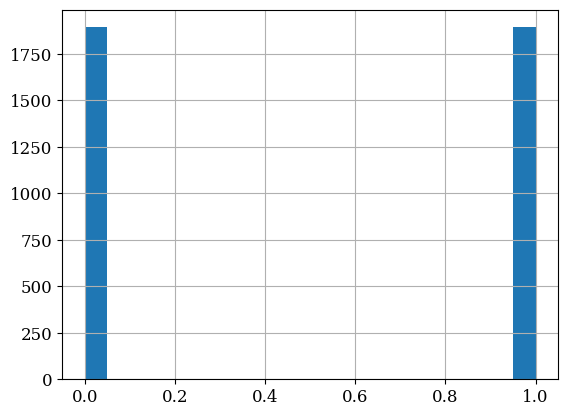

In [39]:
y.hist(bins=20)

In [40]:
# Define a neural network model with batch normalization and dropout
class DeeperNNWithBatchNorm(nn.Module):
    def __init__(self, input_dim, hidden_dim1=256, hidden_dim2=128, hidden_dim3=64, dropout_prob=0.5):
        super(DeeperNNWithBatchNorm, self).__init__()
        # Define layers with batch normalization and dropout
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)

        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_prob)

        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn3 = nn.BatchNorm1d(hidden_dim3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=dropout_prob)

        self.fc4 = nn.Linear(hidden_dim3, 1)  # Single output for binary classification

    def forward(self, x):
        # Forward pass through layers with batch normalization, activation, and dropout
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)  # Linear layer output
        return x

# Function to train the neural network model for binary classification
def train_neural_network_model(X_train, y_train, input_dim, lr=0.001, epochs=1000, hidden_dim1=256, hidden_dim2=128, hidden_dim3=64, dropout_prob=0.5):
    # Initialize the neural network model with specified dimensions and dropout
    model = DeeperNNWithBatchNorm(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, dropout_prob)
    
    # Use Binary Cross Entropy Loss with logits for binary classification
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss (handles sigmoid internally)
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer for better convergence
    
    # Convert training data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(pd.to_numeric(y_train).values, dtype=torch.float32).view(-1, 1)  # Ensure y is of shape [batch_size, 1]
    
    # Store the loss values for visualization
    loss_values = []
    
    # Training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        optimizer.zero_grad()  # Zero gradients
        outputs = model(X_train_tensor)  # Forward pass
        
        # Compute loss (BCEWithLogitsLoss expects raw logits as input)
        loss = criterion(outputs, y_train_tensor)  
        loss.backward()  # Backpropagate loss
        optimizer.step()  # Update weights
        
        # Save loss value for each epoch
        loss_values.append(loss.item())

        # Optional: Print the loss every 100 epochs to monitor progress
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

    # Plot the loss values
    plt.plot(range(epochs), loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.show()

    return model

In [41]:
def predict_classification_model(model, X):
    model.eval()
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    with torch.no_grad():
        probabilities = model(X_tensor).squeeze()
        predictions = (probabilities >= 0.5).float()
    return predictions.numpy()

# Function to evaluate the neural network regression model
def evaluate_model_classification(model, X_train, X_test, y_train, y_test, model_name):
    # Predict on training and test data
    y_train_pred = predict_classification_model(model, X_train)
    y_test_pred = predict_classification_model(model, X_test)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Plot confusion matrix for test data
    test_cm = confusion_matrix(y_test, y_test_pred)
    ConfusionMatrixDisplay(test_cm).plot()
    plt.title(f'Confusion Matrix - Test Data ({model_name})')
    plt.show()

    # Print accuracy results
    print(f"Training Accuracy {model_name}: {train_accuracy:.4f}")
    print(f"Test Accuracy {model_name}: {test_accuracy:.4f}")

In [42]:
# Function to train and evaluate models using the HSLS dataset
def train_and_evaluate_model():
    # Step 1: Process and prepare the HSLS data (assuming `df` is already loaded and cleaned)
    X_all, X_without_sensitive, y = process_hsls_data(df, all_vars)

    # Step 2: Split the data into training and testing sets for both feature sets
    X_train_hp, X_test_hp, y_train, y_test = train_test_split(X_all, y, test_size=0.3, random_state=42)
    X_train_h0, X_test_h0 = train_test_split(X_without_sensitive, test_size=0.3, random_state=42)

    print("Running regression task")

    # Step 3: Train and evaluate model using all features (HP)
    print("Training and evaluating model with all features (HP)...")
    model_hp = train_neural_network_model(X_train_hp, y_train, X_train_hp.shape[1], lr=0.001, epochs=700)
    evaluate_model_classification(model_hp, X_train_hp, X_test_hp, y_train, y_test, "h_p")

    # Step 4: Train and evaluate model excluding sensitive attributes (H0)
    print("\nTraining and evaluating model excluding sensitive attributes (H0)...")
    model_h0 = train_neural_network_model(X_train_h0, y_train, X_train_h0.shape[1], lr=0.001, epochs=700)
    evaluate_model_classification(model_h0, X_train_h0, X_test_h0, y_train, y_test, "h_0")

    # Step 5: Return the necessary objects
    return X_train_hp, X_test_hp, y_train, y_test, X_train_h0, X_test_h0, model_hp, model_h0

In [43]:
def create_gender_race_filters(X_test):
    """
    Create filters for the four groups based on combinations of gender and race.
    Example groups: Female + White, Female + Black, Male + White, Male + Black.
    """
    filters = {}

    # Female + White
    filters['Female + White'] = (X_test['studentgender'] == 2) & (X_test['is_white'] == 1)
    
    # Female + Black
    filters['Female + NonWhite'] = (X_test['studentgender'] == 2) & (X_test['is_white'] == 0)
    
    # Male + White
    filters['Male + White'] = (X_test['studentgender'] == 1) & (X_test['is_white'] == 1)
    
    # Male + Black
    filters['Male + NonWhite'] = (X_test['studentgender'] == 1) & (X_test['is_white'] == 0)

    return filters


def evaluate_model_for_group(y_preds, y_val, group_indices, cost_function, comprehensiveness=False):
    """
    Evaluate predictions for a specific group using a custom cost function.
    Filter predictions and true values using group indices (e.g., gender + race).
    """
    y_group_pred = y_preds[group_indices]
    y_group_val = y_val[group_indices]

    # Compute element-wise loss using the custom cost function
    individual_losses = np.array([cost_function(true, pred) for true, pred in zip(y_group_val, y_group_pred)])

    total_loss = np.mean(individual_losses)
    
    return total_loss, y_group_pred, y_group_val


def evaluate_model_by_combined_groups(y_preds, y_val, filters, cost_function, comprehensiveness=False):
    """
    Evaluate predictions based on combined filters for gender and race.
    """
    group_losses = {}
    group_results = {}

    for group_name, group_indices in filters.items():
        group_loss, group_preds, group_true = evaluate_model_for_group(y_preds, y_val, group_indices, cost_function, comprehensiveness)
        group_losses[group_name] = group_loss
        group_results[group_name] = (group_preds, group_true)

    return group_losses, group_results


def compare_models_by_gender_race_filters(y_preds_hp, y_preds_h0, X_test, y_val_hp, y_val_h0, cost_function, comprehensiveness=False):
    """
    Compare models' predictions dynamically by gender and race using filters.
    """
    # Create filters for gender and race groups
    filters = create_gender_race_filters(X_test)

    # Evaluate total losses for both models using only the subjects with race = 1 or 2
    total_loss_hp = np.mean([cost_function(true, pred) for true, pred in zip(y_val_hp, y_preds_hp)])
    total_loss_h0 = np.mean([cost_function(true, pred) for true, pred in zip(y_val_h0, y_preds_h0)])

    # Evaluate model h_p by group
    group_losses_hp, group_results_hp = evaluate_model_by_combined_groups(y_preds_hp, y_val_hp, filters, cost_function, comprehensiveness)

    # Evaluate model h_0 by group
    group_losses_h0, group_results_h0 = evaluate_model_by_combined_groups(y_preds_h0, y_val_h0, filters, cost_function, comprehensiveness)

    # Print results and calculate differences
    for group_name in filters:
        loss_hp = group_losses_hp[group_name]
        loss_h0 = group_losses_h0[group_name]
        if comprehensiveness:
            loss_hp = -loss_hp
            loss_h0 = -loss_h0
        loss_diff = loss_h0 - loss_hp
        print(f"Group {group_name} - Model h_p: {loss_hp:.4f}, Model h_0: {loss_h0:.4f}, Loss difference: {loss_diff:.4f}")

    if comprehensiveness:
        total_loss_hp = -total_loss_hp
        total_loss_h0 = -total_loss_h0
    print(f"Total loss h_p: {total_loss_hp:.4f}")
    print(f"Total loss h_0: {total_loss_h0:.4f}")
    print(f"Total loss difference: {total_loss_h0 - total_loss_hp:.4f}")

    return group_losses_hp, group_losses_h0

In [44]:
def individual_loss_difference(y_preds_h0, y_preds_hp, y_val_h0, y_val_hp, group_indices, cost_function, title):
    """
    Compute the loss difference between y_preds_h0 and y_preds_hp on a per-individual basis for a given group (e.g., gender + race).
    """
    # Filter predictions and true values for the selected group
    y_preds_h0_filtered = y_preds_h0[group_indices]
    y_preds_hp_filtered = y_preds_hp[group_indices]
    y_vals_h0_filtered = y_val_h0[group_indices]
    y_vals_hp_filtered = y_val_hp[group_indices]

    if title == "Comprehensiveness":
        # Negate the losses for comprehensiveness
        individual_diff = np.array([cost_function(val_hp, pred_hp) - cost_function(val_h0, pred_h0)
                                    for val_h0, val_hp, pred_h0, pred_hp in zip(y_vals_h0_filtered, y_vals_hp_filtered, y_preds_h0_filtered, y_preds_hp_filtered)])
    else:
        # Compute individual element-wise losses using the custom cost function
        individual_diff = np.array([cost_function(val_h0, pred_h0) - cost_function(val_hp, pred_hp)
                                    for val_h0, val_hp, pred_h0, pred_hp in zip(y_vals_h0_filtered, y_vals_hp_filtered, y_preds_h0_filtered, y_preds_hp_filtered)])

    return individual_diff

# Apply consistent plot settings
plt.rcParams["font.family"] = "serif"  # Use serif font
plt.rcParams["font.size"] = 14  # Standard font size for plots
plt.rcParams["axes.labelsize"] = 14  # Font size for x and y labels
plt.rcParams["axes.titlesize"] = 16  # Font size for titles
plt.rcParams["legend.fontsize"] = 12  # Font size for legends
plt.rcParams["xtick.labelsize"] = 12  # Font size for x-tick labels
plt.rcParams["ytick.labelsize"] = 12  # Font size for y-tick labels

def plot_loss_difference_histogram(y_preds_h0, y_preds_hp, X_test, y_val_h0, y_val_hp, cost_function, title):
    """
    Generate histograms of the loss difference between two sets of predictions (h0 and hp) for multiple groups using a custom element-wise cost function.
    Displays standard deviation in the upper left corner of each subplot.
    """
    # Create filters for the groups (assumes `create_gender_race_filters` is defined based on gender and race)
    filters = create_gender_race_filters(X_test)

    # Determine the number of rows and columns based on the number of groups for subplots
    num_filters = len(filters)
    num_cols = 2
    num_rows = int(np.ceil(num_filters / num_cols))

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
    axes = axes.flatten()  # Flatten in case of multi-dimensional array

    # Adjust the cost function name for display purposes
    if cost_function.__name__ == 'zero_one_loss':
        cost_function_name = 'Zero-One Loss'
    else:
        cost_function_name = cost_function.__name__

    # Set the overall title for the entire figure, closer to the subplots
    fig.suptitle(f'{cost_function_name} Difference Histogram per Subgroup', fontsize=20, y=0.98)

    for i, (group_name, group_indices) in enumerate(filters.items(), start=0):
        # Compute loss differences for each group
        group_loss_diff = individual_loss_difference(
            y_preds_h0, y_preds_hp, y_val_h0, y_val_hp, group_indices, cost_function, title
        )

        # Calculate standard deviation
        stddev = np.std(group_loss_diff)

        # Plot histogram for each group
        axes[i].hist(group_loss_diff, bins=30, alpha=0.7, color='#007791')  # Use a consistent color for histograms
        axes[i].set_title(f'{group_name} ({title})', fontsize=16)  # Title specific to each group
        axes[i].set_xlabel('Difference in Loss', fontsize=14)
        axes[i].set_ylabel('Frequency', fontsize=14)

    # Remove any unused subplots (if filters count is less than number of subplots)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout and overall spacing to accommodate the suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.94])  # Leave some space for the top title
    plt.subplots_adjust(top=0.88)  # Adjust the top spacing to bring the title closer to subplots
    plt.show()

In [45]:
# For scalars
def squared_error(true_value, pred_value):
    return (true_value - pred_value) ** 2

def zero_one_loss(true_value, pred_prob):
    pred_label = 1 if pred_prob >= 0.5 else 0
    if 0 < true_value < 1:  # If the true value is a probability, convert to binary label, this is for the case of explainers
        true_value = 1 if true_value >= 0.5 else 0
    return 1 if true_value != pred_label else 0

def binary_cross_entropy_loss(true_value, pred_prob):
    epsilon = 1e-12
    pred_prob = np.clip(pred_prob, epsilon, 1. - epsilon)
    loss = -(true_value * np.log(pred_prob) + (1 - true_value) * np.log(1 - pred_prob))
    return loss

In [46]:
# Function to apply Integrated Gradients
def explain_with_ig(model, X_test):
    ig = IntegratedGradients(model)
    
    # Convert the test set to PyTorch tensor
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Compute attributions using Integrated Gradients
    attributions, delta = ig.attribute(X_test_tensor, return_convergence_delta=True)
    # Print the shape of attributions
    print("Shape of attributions:", attributions.shape)
    
    return attributions, delta

# Function to calculate comprehensiveness
def comprehensiveness(model, X_test, attributions, top_k):
    model.eval()
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Sort attributions by importance
    top_attributions = torch.argsort(attributions, descending=True)

    # Remove top_k important features
    for i in range(X_test_tensor.size(0)):
        top_features = top_attributions[i, :top_k]
        X_test_tensor[i, top_features] = 0
    
    # Re-run the model to get new predictions with removed features
    #print("X_test_tensor shape", X_test_tensor.shape)
    with torch.no_grad():
        new_predictions = model(X_test_tensor).squeeze().numpy()

    return new_predictions

# Function to calculate(sufficiency)
def sufficiency(model, X_test, attributions, top_k):
    model.eval()
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Sort attributions by importance
    top_attributions = torch.argsort(attributions, descending=True)
    
    # Keep only top_k important features and zero out the rest
    for i in range(X_test_tensor.size(0)):
        mask = torch.zeros(X_test_tensor.size(1), dtype=torch.float32)
        top_features = top_attributions[i, :top_k]
        mask[top_features] = 1
        X_test_tensor[i] = X_test_tensor[i] * mask
    
    # Re-run the model to get new predictions with only important features
    with torch.no_grad():
        new_predictions = model(X_test_tensor).squeeze().numpy()
    
    return new_predictions


In [47]:
def plot_group_losses(ks, hp_comp_list, h0_comp_list, hp_suff_list, h0_suff_list, group_name, cost_function, row_index):
    """
    Helper function to plot comprehensiveness and sufficiency losses for a specific group.
    """
    plt.subplot(4, 2, row_index)
    plt.plot(ks, hp_comp_list, label=f'{group_name} $h_{{p}}$', marker='o')
    plt.plot(ks, h0_comp_list, label=f'{group_name} $h_{{0}}$', marker='o')
    plt.xlabel('Top r Features Removed')
    plt.ylabel(f'{cost_function.__name__} Loss')
    plt.title(f'{group_name} Comprehensiveness')
    plt.legend()

    plt.subplot(4, 2, row_index + 4)  # Sufficiency plots in lower half
    plt.plot(ks, hp_suff_list, label=f'{group_name} $h_{{p}}$', marker='o')
    plt.plot(ks, h0_suff_list, label=f'{group_name} $h_{{0}}$', marker='o')
    plt.xlabel('Top r Features Removed')
    plt.ylabel(f'{cost_function.__name__} Loss')
    plt.title(f'{group_name} Sufficiency')
    plt.legend()

def plot_loss_by_groups_over_ks(model_hp, model_h0, X_test_hp, X_test_h0, y_preds_hp, y_preds_h0, attributions_hp, attributions_h0, cost_function, ks):
    """
    Plot loss differences for comprehensiveness and sufficiency over the four groups (Female/Male + Good/Poor Health)
    for different top_k feature removal.
    """
    # Initialize dictionaries to store the results
    group_names = ['Female + White', 'Female + NonWhite', 'Male + White', 'Male + NonWhite']
    
    comp_lists_hp = {group: [] for group in group_names}
    comp_lists_h0 = {group: [] for group in group_names}
    suff_lists_hp = {group: [] for group in group_names}
    suff_lists_h0 = {group: [] for group in group_names}

    # Loop over different top_k values
    for top_k in ks:
        # Comprehensiveness and Sufficiency predictions
        comprehensiveness_preds_hp = comprehensiveness(model_hp, X_test_hp, attributions_hp, top_k)
        comprehensiveness_preds_h0 = comprehensiveness(model_h0, X_test_h0, attributions_h0, top_k)
        sufficiency_preds_hp = sufficiency(model_hp, X_test_hp, attributions_hp, top_k)
        sufficiency_preds_h0 = sufficiency(model_h0, X_test_h0, attributions_h0, top_k)

        # Filters for groups
        filters = create_gender_race_filters(X_test_hp)

        # Loop over groups and calculate losses
        for group_name, group_indices in filters.items():
            # Comprehensiveness
            group_hp_comp, group_h0_comp = compare_models_by_gender_race_filters(
                comprehensiveness_preds_hp, comprehensiveness_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, cost_function, comprehensiveness=True)
            
            # Sufficiency
            group_hp_suff, group_h0_suff = compare_models_by_gender_race_filters(
                sufficiency_preds_hp, sufficiency_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, cost_function)
            
            # Store results
            comp_lists_hp[group_name].append(group_hp_comp[group_name])
            comp_lists_h0[group_name].append(group_h0_comp[group_name])
            suff_lists_hp[group_name].append(group_hp_suff[group_name])
            suff_lists_h0[group_name].append(group_h0_suff[group_name])

    # Plot comprehensiveness and sufficiency for each group
    plt.figure(figsize=(14, 12))
    
    for i, group_name in enumerate(group_names, start=1):
        plot_group_losses(ks, comp_lists_hp[group_name], comp_lists_h0[group_name],
                          suff_lists_hp[group_name], suff_lists_h0[group_name], group_name, cost_function, i)

    plt.tight_layout()
    plt.show()

Shape after removing invalid values: (5683, 66)
Shape after filtering for valid race values: (5683, 66)
Shape after balancing White and Nonwhite groups: (3786, 67)
Shape of X_all: (3786, 89)
Shape of X_without_sensitive: (3786, 87)
Running regression task
Training and evaluating model with all features (HP)...
Epoch [100/700], Loss: 0.5374
Epoch [200/700], Loss: 0.4928
Epoch [300/700], Loss: 0.4574
Epoch [400/700], Loss: 0.4233
Epoch [500/700], Loss: 0.3849
Epoch [600/700], Loss: 0.3278
Epoch [700/700], Loss: 0.2955


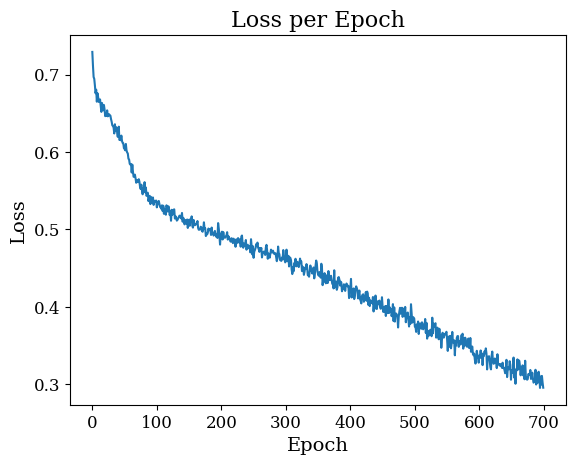

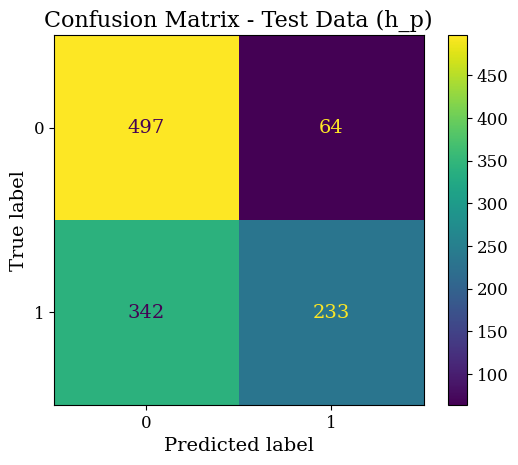

Training Accuracy h_p: 0.7857
Test Accuracy h_p: 0.6426

Training and evaluating model excluding sensitive attributes (H0)...
Epoch [100/700], Loss: 0.5339
Epoch [200/700], Loss: 0.5004
Epoch [300/700], Loss: 0.4695
Epoch [400/700], Loss: 0.4361
Epoch [500/700], Loss: 0.3794
Epoch [600/700], Loss: 0.3700
Epoch [700/700], Loss: 0.3124


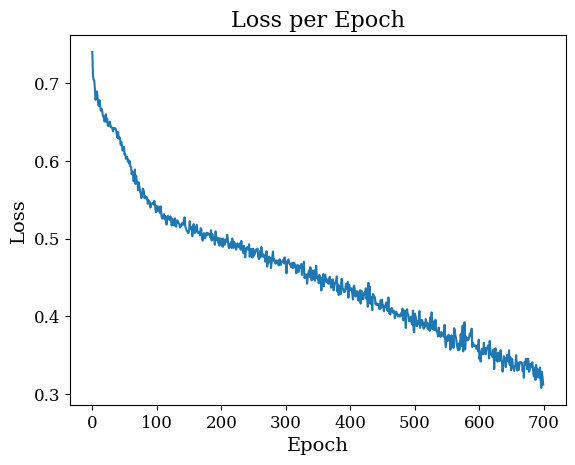

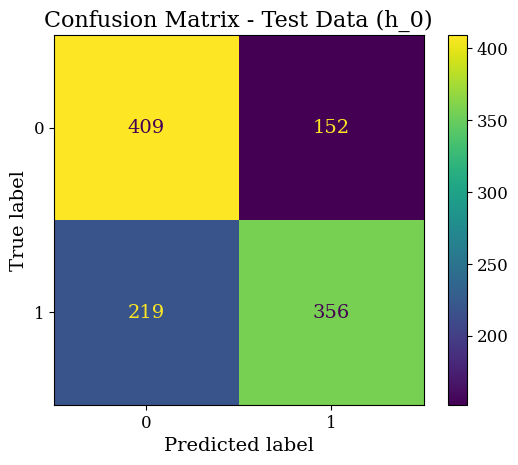

Training Accuracy h_0: 0.8747
Test Accuracy h_0: 0.6734


In [48]:
X_train_hp, X_test_hp, y_train, y_test, X_train_h0, X_test_h0, model_hp, model_h0 = train_and_evaluate_model()

For test data:
Number of individuals in 'Female + White':  287
Number of individuals in 'Female + NonWhite':  274
Number of individuals in 'Male + White':  301
Number of individuals in 'Male + NonWhite':  274
Group Female + White - Model h_p: 0.4077, Model h_0: 0.3449, Loss difference: -0.0627
Group Female + NonWhite - Model h_p: 0.3248, Model h_0: 0.3358, Loss difference: 0.0109
Group Male + White - Model h_p: 0.4086, Model h_0: 0.3389, Loss difference: -0.0698
Group Male + NonWhite - Model h_p: 0.2810, Model h_0: 0.2847, Loss difference: 0.0036
Total loss h_p: 0.3574
Total loss h_0: 0.3266
Total loss difference: -0.0308
For training data:


Number of individuals in 'Female + White':  651
Number of individuals in 'Female + NonWhite':  688
Number of individuals in 'Male + White':  654
Number of individuals in 'Male + NonWhite':  657
Group Female + White - Model h_p: 0.2673, Model h_0: 0.1490, Loss difference: -0.1183
Group Female + NonWhite - Model h_p: 0.2020, Model h_0: 0.1047, Loss difference: -0.0974
Group Male + White - Model h_p: 0.2187, Model h_0: 0.1330, Loss difference: -0.0856
Group Male + NonWhite - Model h_p: 0.1705, Model h_0: 0.1157, Loss difference: -0.0548
Total loss h_p: 0.2143
Total loss h_0: 0.1253
Total loss difference: -0.0891


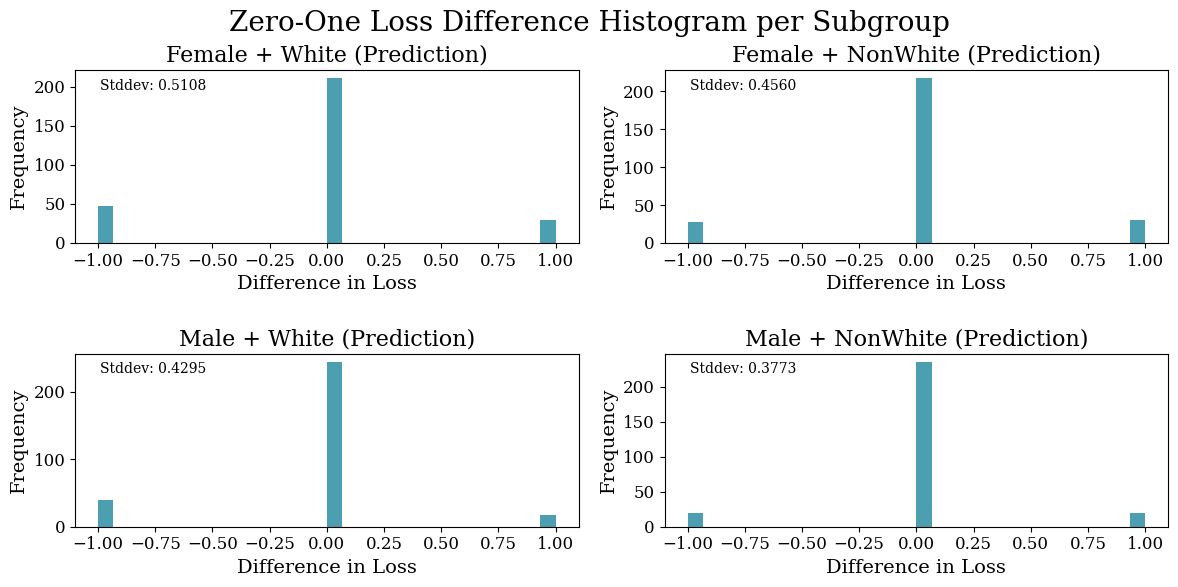

In [49]:
# Step 2: Generate predictions for both models (h_p and h_0)
y_preds_hp = predict_classification_model(model_hp, X_test_hp)  # Using the model trained with all features (h_p)
y_preds_h0 = predict_classification_model(model_h0, X_test_h0)  # Using the model trained excluding gender and race (h_0)

# Use the same true labels for both models
y_test_hp = y_test
y_test_h0 = y_test

# Step 3: Compare models by gender and race using regression cost function (mean squared error)
print("For test data:")
filters = create_gender_race_filters(X_test_hp)
print("Number of individuals in 'Female + White': ", (filters['Female + White']).sum())
print("Number of individuals in 'Female + NonWhite': ", (filters['Female + NonWhite']).sum())
print("Number of individuals in 'Male + White': ", (filters['Male + White']).sum())
print("Number of individuals in 'Male + NonWhite': ", (filters['Male + NonWhite']).sum())

# Compare model performance using the defined filters
group_losses_hp, group_losses_h0 = compare_models_by_gender_race_filters(
    y_preds_hp, y_preds_h0, X_test_hp, y_test_hp, y_test_h0, zero_one_loss, comprehensiveness=False
)

print("For training data:")
# Generate predictions for training data
y_preds_hp_train = predict_classification_model(model_hp, X_train_hp)
y_preds_h0_train = predict_classification_model(model_h0, X_train_h0)

# Display number of individuals in each group (based on gender + race)
filters_train = create_gender_race_filters(X_train_hp)
print("Number of individuals in 'Female + White': ", (filters_train['Female + White']).sum())
print("Number of individuals in 'Female + NonWhite': ", (filters_train['Female + NonWhite']).sum())
print("Number of individuals in 'Male + White': ", (filters_train['Male + White']).sum())
print("Number of individuals in 'Male + NonWhite': ", (filters_train['Male + NonWhite']).sum())

# True labels for training data
y_train_hp = y_train
y_train_h0 = y_train

# Compare models for training data
group_losses_hp_train, group_losses_h0_train = compare_models_by_gender_race_filters(
    y_preds_hp_train, y_preds_h0_train, X_train_hp, y_train_hp, y_train_h0, zero_one_loss, comprehensiveness=False
)

# Step 4: Plot loss difference histograms for model predictions using mean squared error
plot_loss_difference_histogram(y_preds_h0, y_preds_hp, X_test_hp, y_test_h0, y_test_hp, zero_one_loss, "Prediction")

In [50]:
# Step 5: Generate explanations with Integrated Gradients for test and training data
attributions_hp, _ = explain_with_ig(model_hp, X_test_hp)
attributions_h0, _ = explain_with_ig(model_h0, X_test_h0)

# Generate explanations for training data
attributions_hp_train, _ = explain_with_ig(model_hp, X_train_hp)
attributions_h0_train, _ = explain_with_ig(model_h0, X_train_h0)

Shape of attributions: torch.Size([1136, 89])
Shape of attributions: torch.Size([1136, 87])
Shape of attributions: torch.Size([2650, 89])
Shape of attributions: torch.Size([2650, 87])


For testing data explainer


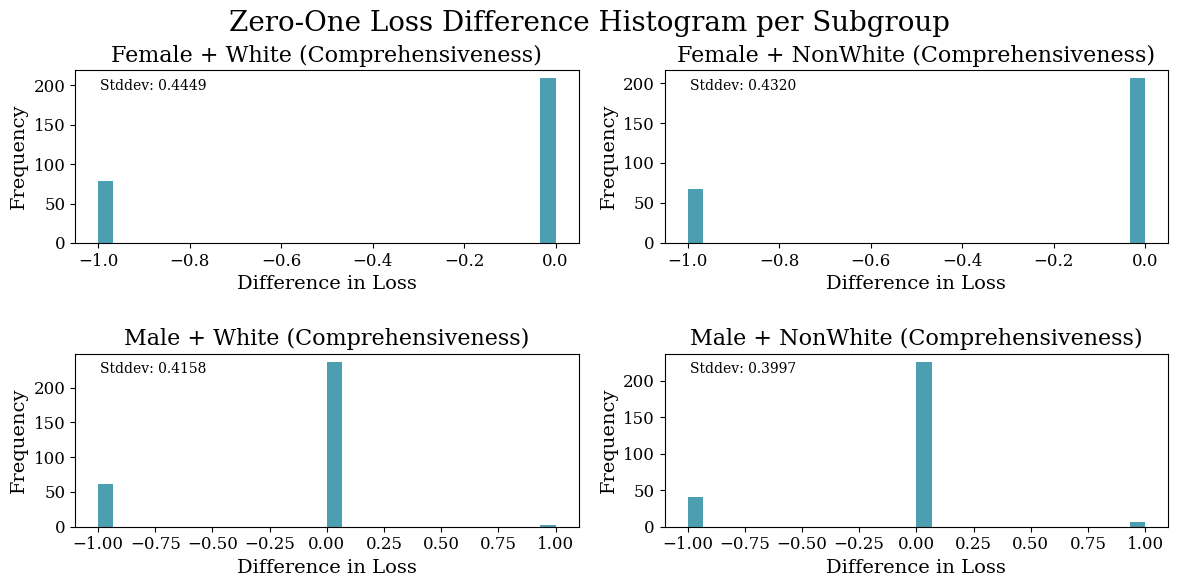

Group Female + White - Model h_p: -0.1777, Model h_0: -0.4495, Loss difference: -0.2718
Group Female + NonWhite - Model h_p: -0.2445, Model h_0: -0.4927, Loss difference: -0.2482
Group Male + White - Model h_p: -0.3023, Model h_0: -0.5017, Loss difference: -0.1993
Group Male + NonWhite - Model h_p: -0.3212, Model h_0: -0.4453, Loss difference: -0.1241
Total loss h_p: -0.2614
Total loss h_0: -0.4727
Total loss difference: -0.2113


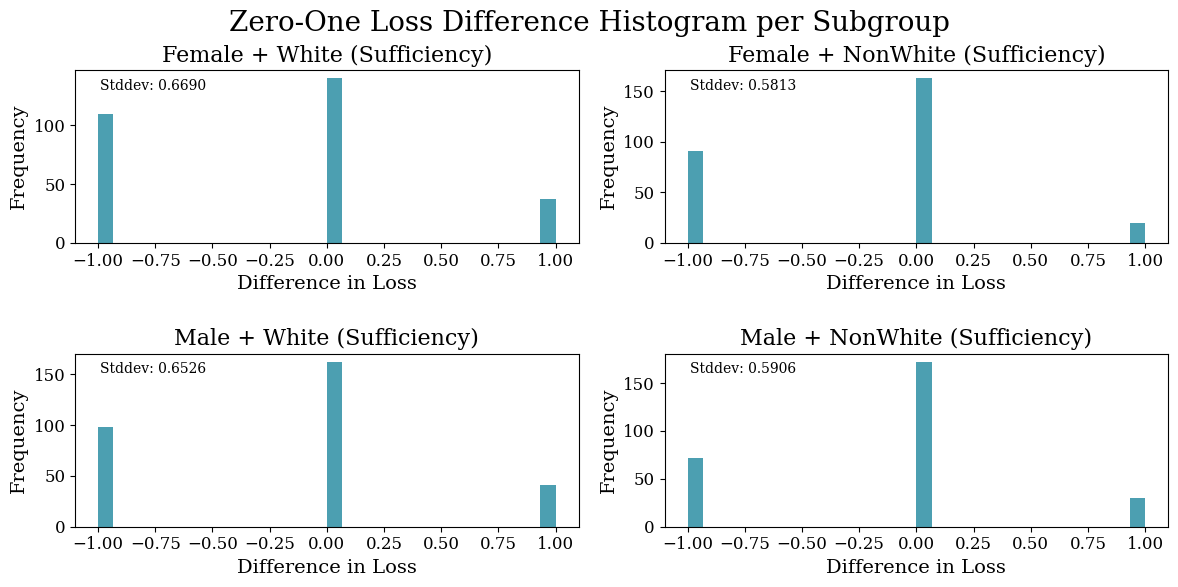

Group Female + White - Model h_p: 0.5540, Model h_0: 0.2997, Loss difference: -0.2544
Group Female + NonWhite - Model h_p: 0.4672, Model h_0: 0.2080, Loss difference: -0.2591
Group Male + White - Model h_p: 0.4784, Model h_0: 0.2890, Loss difference: -0.1894
Group Male + NonWhite - Model h_p: 0.3686, Model h_0: 0.2153, Loss difference: -0.1533
Total loss h_p: 0.4683
Total loss h_0: 0.2544
Total loss difference: -0.2139
For training data explainer
Group Female + White - Model h_p: -0.2550, Model h_0: -0.5084, Loss difference: -0.2535
Group Female + NonWhite - Model h_p: -0.2674, Model h_0: -0.4433, Loss difference: -0.1759
Group Male + White - Model h_p: -0.3135, Model h_0: -0.4862, Loss difference: -0.1728
Group Male + NonWhite - Model h_p: -0.3744, Model h_0: -0.5114, Loss difference: -0.1370
Total loss h_p: -0.3023
Total loss h_0: -0.4868
Total loss difference: -0.1845
Group Female + White - Model h_p: 0.5253, Model h_0: 0.3057, Loss difference: -0.2197
Group Female + NonWhite - Mode

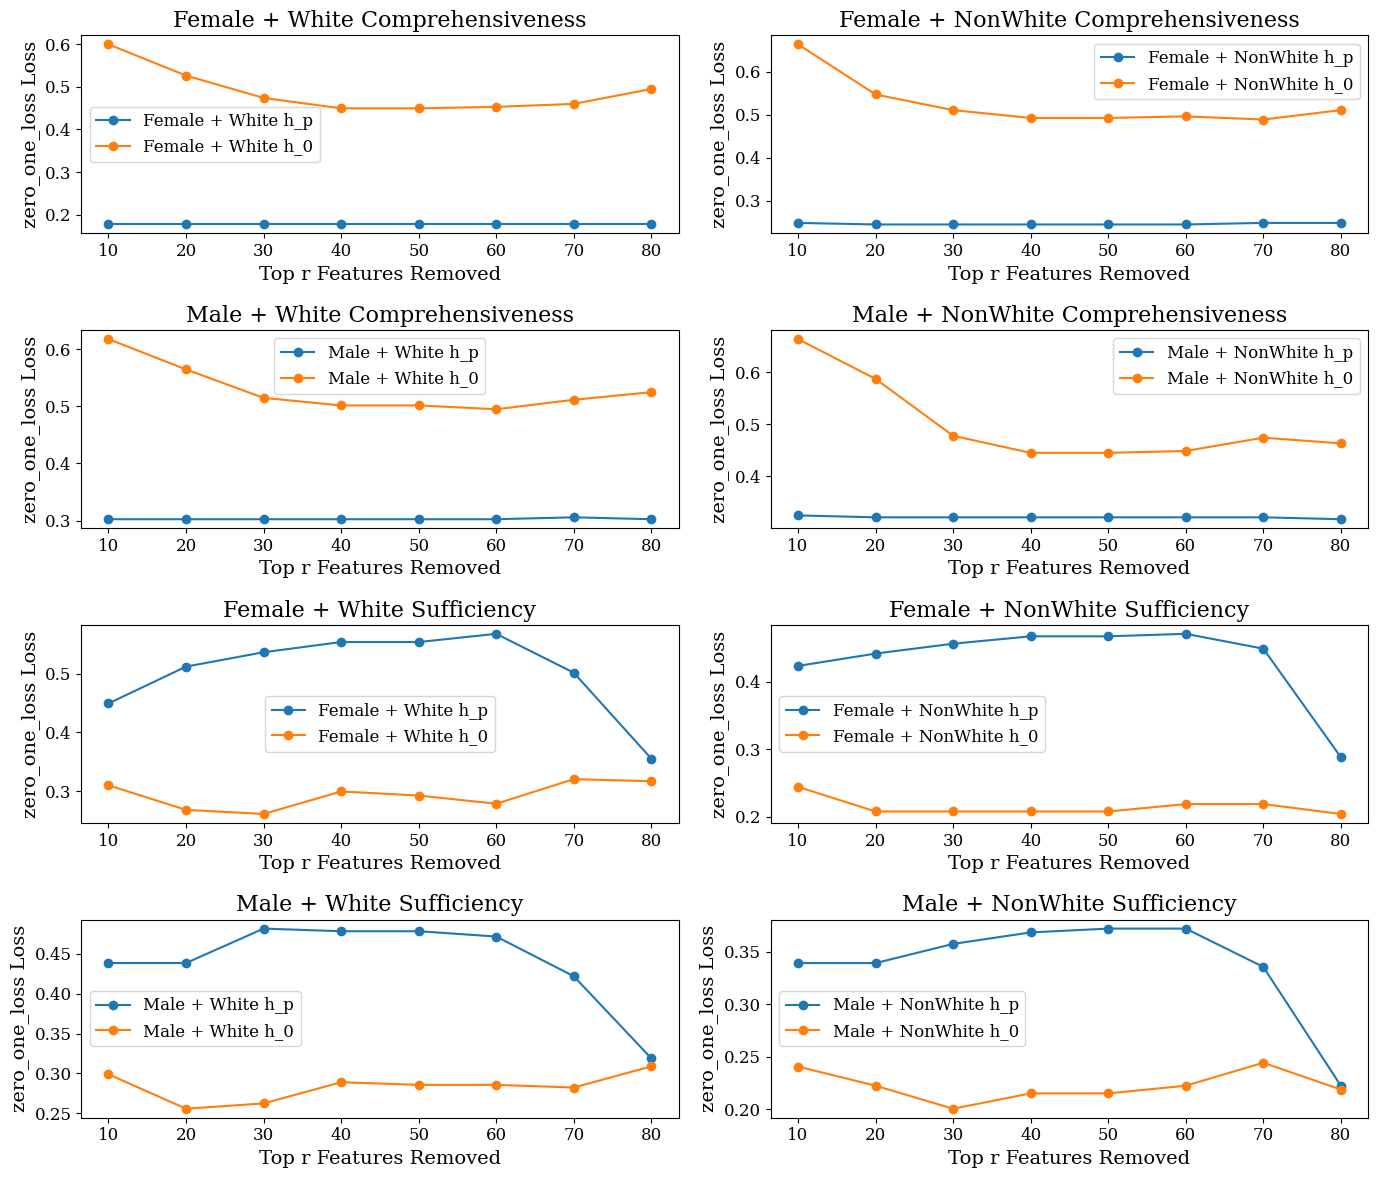

In [51]:
top_k = 40  # Adjust the number of top features to remove

# Step 6: Analyze comprehensiveness for test data
print("For testing data explainer")
comprehensiveness_preds_hp_reg = comprehensiveness(model_hp, X_test_hp, attributions_hp, top_k)
comprehensiveness_preds_h0_reg = comprehensiveness(model_h0, X_test_h0, attributions_h0, top_k)

# Plot loss differences for comprehensiveness
plot_loss_difference_histogram(comprehensiveness_preds_h0_reg, comprehensiveness_preds_hp_reg, X_test_hp, y_preds_h0, y_preds_hp, zero_one_loss, "Comprehensiveness")

# Compare models for comprehensiveness
group_losses_hp, group_losses_h0 = compare_models_by_gender_race_filters(comprehensiveness_preds_hp_reg, comprehensiveness_preds_h0_reg, X_test_hp, y_preds_hp, y_preds_h0, zero_one_loss, comprehensiveness=True)

# Step 7: Analyze sufficiency for test data
sufficiency_preds_hp = sufficiency(model_hp, X_test_hp, attributions_hp, top_k)
sufficiency_preds_h0 = sufficiency(model_h0, X_test_h0, attributions_h0, top_k)

# Plot loss differences for sufficiency
plot_loss_difference_histogram(sufficiency_preds_h0, sufficiency_preds_hp, X_test_hp, y_preds_h0, y_preds_hp, zero_one_loss, "Sufficiency")

# Compare models for sufficiency
group_losses_hp, group_losses_h0 = compare_models_by_gender_race_filters(sufficiency_preds_hp, sufficiency_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, zero_one_loss, comprehensiveness=False)

# Step 8: Analyze comprehensiveness for training data
print("For training data explainer")
comprehensiveness_preds_hp_train_reg = comprehensiveness(model_hp, X_train_hp, attributions_hp_train, top_k)
comprehensiveness_preds_h0_train_reg = comprehensiveness(model_h0, X_train_h0, attributions_h0_train, top_k)

# Compare models for comprehensiveness on training data
group_losses_hp_train, group_losses_h0_train = compare_models_by_gender_race_filters(comprehensiveness_preds_hp_train_reg, comprehensiveness_preds_h0_train_reg, X_train_hp, y_preds_hp_train, y_preds_h0_train, zero_one_loss, comprehensiveness=True)

# Step 9: Analyze sufficiency for training data
sufficiency_preds_hp_train = sufficiency(model_hp, X_train_hp, attributions_hp_train, top_k)
sufficiency_preds_h0_train = sufficiency(model_h0, X_train_h0, attributions_h0_train, top_k)

# Compare models for sufficiency on training data
group_losses_hp_train, group_losses_h0_train = compare_models_by_gender_race_filters(sufficiency_preds_hp_train, sufficiency_preds_h0_train, X_train_hp, y_preds_hp_train, y_preds_h0_train, zero_one_loss, comprehensiveness=False)

# Step 10: Plot loss differences for various values of k
ks = [10, 20, 30, 40, 50, 60, 70, 80]  # Example range of k values
plot_loss_by_groups_over_ks(model_hp, model_h0, X_test_hp, X_test_h0, y_preds_hp, y_preds_h0, attributions_hp, attributions_h0, zero_one_loss, ks)


In [11]:
# Evaluate Pe
def lower_bound_categorical(k, n=1000, epsilon=0.01):
    """Compute the lower bound to Pe for the binary valued cost function case.

    BOP is a categorical variable.
    """
    d = 2 ** k
    m = n / d
    parenthesis_term = ( 1 + 4 * epsilon ** 2)**(m/2)
    frac_term = 1 / (2*np.sqrt(d))
    return 1 - frac_term * parenthesis_term

k=2
n = 1136
lower_bound_categorical(2, 1136)

0.735391980061546